## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:

results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 7s 145us/step - loss: 2.4626 - accuracy: 0.0995 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.4626 - accuracy: 0.0985 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.7860 - accuracy: 0.6245 - val_loss: 3.2633 - val_accuracy: 0.4723
Epoch 47/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.7517 - accuracy: 0.6256 - val_loss: 2.9985 - val_accuracy: 0.5347
Epoch 48/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.7133 - accuracy: 0.6253 - val_loss: 3.0143 - val_accuracy: 0.5218
Epoch 49/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.6764 - accuracy: 0.6307 - val_loss: 2.9275 - val_accuracy: 0.5320
Epoch 50/50
50000/50000 [==============================] - 7s 145us/step - loss: 2.6421 - accuracy: 0.6270 - val_loss: 2.9640 - val_accuracy: 0.5143
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 7s 142us/step - loss: 0.9432 - accuracy: 0.6711 - val_loss: 1.4497 - val_accuracy: 0.5119
Epoch 44/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.9325 - accuracy: 0.6738 - val_loss: 1.3733 - val_accuracy: 0.5359
Epoch 45/50
50000/50000 [==============================] - 9s 176us/step - loss: 0.9235 - accuracy: 0.6780 - val_loss: 1.3882 - val_accuracy: 0.5228
Epoch 46/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.9129 - accuracy: 0.6798 - val_loss: 1.3915 - val_accuracy: 0.5336
Epoch 47/50
50000/50000 [==============================] - 7s 144us/step - loss: 0.8959 - accuracy: 0.6872 - val_loss: 1.3991 - val_accuracy: 0.5348
Epoch 48/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.8838 - accuracy: 0.6908 - val_loss: 1.4313 - val_accuracy: 0.5291
Epoch 49/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.8700 - accuracy: 0.6967 - val_loss:

Epoch 41/50
50000/50000 [==============================] - 7s 149us/step - loss: 0.9836 - accuracy: 0.6546 - val_loss: 1.3470 - val_accuracy: 0.5352
Epoch 42/50
50000/50000 [==============================] - 7s 150us/step - loss: 0.9765 - accuracy: 0.6580 - val_loss: 1.5027 - val_accuracy: 0.4930
Epoch 43/50
50000/50000 [==============================] - 8s 151us/step - loss: 0.9613 - accuracy: 0.6612 - val_loss: 1.3655 - val_accuracy: 0.5291
Epoch 44/50
50000/50000 [==============================] - 7s 150us/step - loss: 0.9497 - accuracy: 0.6662 - val_loss: 1.3482 - val_accuracy: 0.5398
Epoch 45/50
50000/50000 [==============================] - 8s 156us/step - loss: 0.9399 - accuracy: 0.6705 - val_loss: 1.3978 - val_accuracy: 0.5256
Epoch 46/50
50000/50000 [==============================] - 7s 149us/step - loss: 0.9287 - accuracy: 0.6740 - val_loss: 1.4483 - val_accuracy: 0.5141
Epoch 47/50
50000/50000 [==============================] - 7s 149us/step - loss: 0.9114 - accuracy: 0.6793

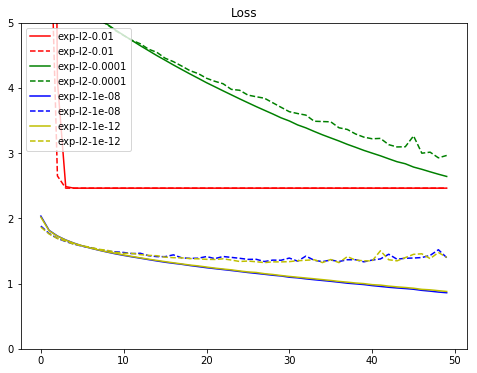

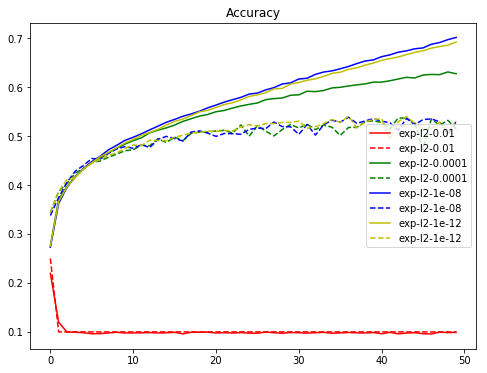

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 161us/step - loss: 2.4614 - accuracy: 0.0971 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.4614 - accuracy: 0.0985 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.4614 - accuracy: 0.0989 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 8s 157us/step - loss: 1.7686 - accuracy: 0.4742 - val_loss: 1.8026 - val_accuracy: 0.4609
Epoch 46/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.7637 - accuracy: 0.4746 - val_loss: 1.8090 - val_accuracy: 0.4493
Epoch 47/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.7601 - accuracy: 0.4757 - val_loss: 1.7736 - val_accuracy: 0.4684
Epoch 48/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.7565 - accuracy: 0.4761 - val_loss: 1.7919 - val_accuracy: 0.4523
Epoch 49/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.7535 - accuracy: 0.4770 - val_loss: 1.7627 - val_accuracy: 0.4753
Epoch 50/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7532 - accuracy: 0.4783 - val_loss: 1.7861 - val_accuracy: 0.4614
Experiment with Regulizer = 0.000000
Model: "model_1"
________________________________________________________________

Epoch 43/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6395 - accuracy: 0.5158 - val_loss: 1.7043 - val_accuracy: 0.4947
Epoch 44/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.6376 - accuracy: 0.5157 - val_loss: 1.6939 - val_accuracy: 0.4914
Epoch 45/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6310 - accuracy: 0.5184 - val_loss: 1.7499 - val_accuracy: 0.4744
Epoch 46/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.6278 - accuracy: 0.5212 - val_loss: 1.6932 - val_accuracy: 0.4953
Epoch 47/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.6245 - accuracy: 0.5189 - val_loss: 1.6685 - val_accuracy: 0.5030
Epoch 48/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.6195 - accuracy: 0.5217 - val_loss: 1.7274 - val_accuracy: 0.4745
Epoch 49/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6177 - accuracy: 0.5236

50000/50000 [==============================] - 8s 161us/step - loss: 1.6606 - accuracy: 0.5091 - val_loss: 1.7248 - val_accuracy: 0.4828
Epoch 41/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.6540 - accuracy: 0.5115 - val_loss: 1.8176 - val_accuracy: 0.4335
Epoch 42/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6486 - accuracy: 0.5116 - val_loss: 1.7312 - val_accuracy: 0.4798
Epoch 43/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6412 - accuracy: 0.5128 - val_loss: 1.7323 - val_accuracy: 0.4806
Epoch 44/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6354 - accuracy: 0.5162 - val_loss: 1.6856 - val_accuracy: 0.4939
Epoch 45/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6336 - accuracy: 0.5136 - val_loss: 1.7405 - val_accuracy: 0.4678
Epoch 46/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.6274 - accuracy: 0.5163 - val_loss:

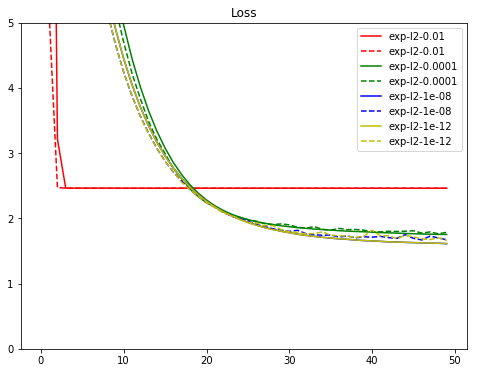

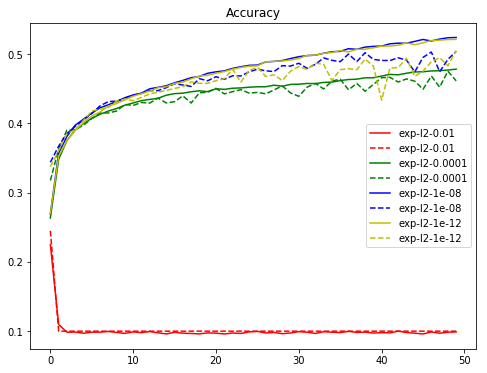

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}



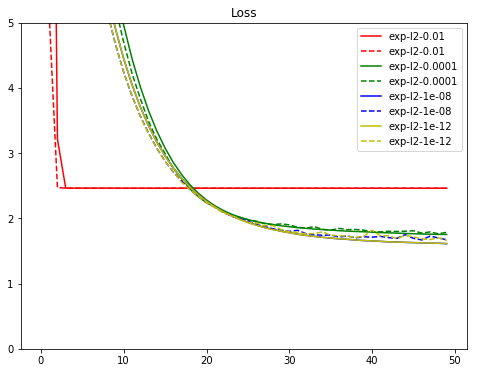

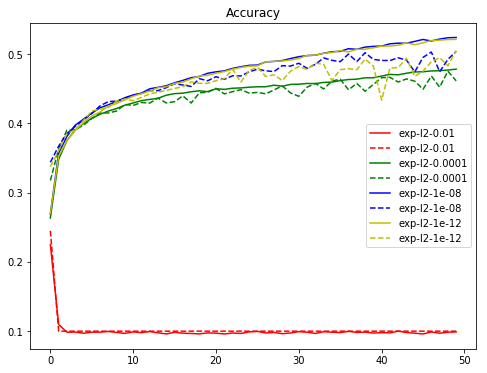

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show() 